### Binary protrusion segmentation

The task of binary segmentation is to label each vertex (or alternatively face) of a mesh as being on a protrusion - 1, or not on a protrusion - 0.   

We will do this by measuring the 'height' of a vertex from a constructed reference. 

<div class="alert alert-block alert-info"> 
<b>NOTE</b> The reference used for measuring height need not be that used for unwrapping. It may be more optimal to construct a different reference depending on the problem as we show.
</div>

The mesh we we will use to demonstrate is `../../data/mesh/lamellipodia_cell.obj`, as well as its corresponding topography mesh `../../data/mesh/topography/curvature_topographic_mesh_lamellipodia_cell.obj`. The method demonstrated generalizes for all protrusions, but may require tweaking of parameters. 

#### 0. Read in the surface mesh

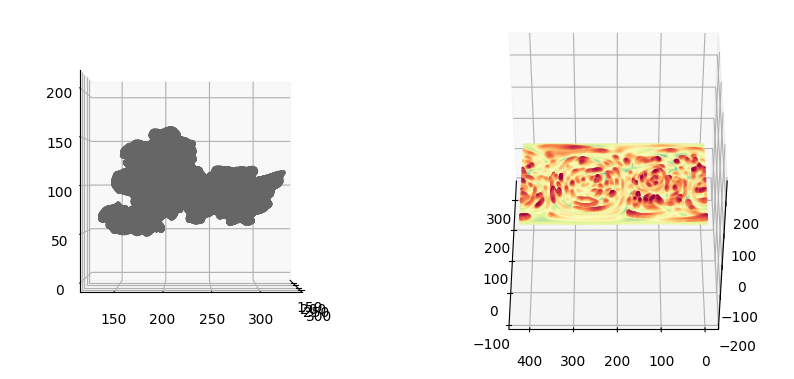

In [29]:
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions
import unwrap3D.Unzipping.unzip as uzip
import unwrap3D.Visualisation.colors as vol_colors
import unwrap3D.Visualisation.plotting as plotting

from matplotlib import cm 
import os
import numpy as np
import pylab as plt 

"""
Specifying image file location and parsing its name. 
"""
meshfolder = '../../data/mesh'
meshfile = os.path.join(meshfolder, 'lamellipodia_cell.obj')

basefname = os.path.split(meshfile)[-1].split('.obj')[0] # get the filename with extension

mesh_S = meshtools.read_mesh(meshfile,
                             keep_largest_only=True) # read only the largest if there is multiple separate objects in the mesh

"""
Also get its topography mesh
"""
topo_meshfile = os.path.join(meshfolder, 'topography', 'curvature_topographic_mesh_lamellipodia_cell.obj')
mesh_S_duv = meshtools.read_mesh(topo_meshfile, 
                                 keep_largest_only=True)

"""
Create a master save folder
"""
savefolder = os.path.join('example_results', 
                         basefname)
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Visualize the input mesh
"""
sampling = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.5, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(45,180)
plotting.set_axes_equal(ax)
plt.show()


#### 1. Defining a vertex-based protrusion height 

The function should measure protrusion 'height'. However, the height of a protrusion is a relative concept, necessarily requiring a reference surface to measure with respect to. 

We explore 3 different constructions of a reference surface to derive 3 different heights for binary segmentation:

- cMCF $S_\text{ref}(x,y,z)$
- cMCF + distance function $S_\text{ref}(x,y,z)$ 
- asymmetric least squares (ALS) baseline reference,$S_\text{ref}(d,u,v)$ (for $S(d,u,v)$ only)

##### cMCF $S_\text{ref}(x,y,z)$

Running cMCF and stopping criteria for this cell was explained as a fully worked example in the standard workflow section. For clarity, we repeat the code here, and recompute the reference here 

In [30]:
Usteps_MCF_img, mesh_F, MCF_measures_dict = meshtools.conformalized_mean_curvature_flow(mesh_S, 
                                                                                    max_iter=50, 
                                                                                    rescale_output = True, # cMCF is solved in normalized coordinates, when True, the output will be rescaled to be in image coordinates.  
                                                                                    delta=5e-4, 
                                                                                    conformalize=True, # set this flag to run cMCF, else it will run MCF
                                                                                    robust_L =False, # if set, runs MCF/cMCF using the robust Laplacian instead of cotangent Laplacian
                                                                                    mollify_factor=1e-5, # this is a parameter used in the robust Laplacian
                                                                                    solver='pardiso')  # 'scipy': standard scipy solver, 'pardiso' for using Intel's pardiso solver to solve in parallel. 'pariso' is much faster. But you must use 'scipy' if you plan to multiprocess over different cells.

gauss_curve_MCF = MCF_measures_dict['gauss_curvature_iter'].copy()

# find changepoints in the curve, generally default is fine.
inds = meshtools.find_all_curvature_cutoff_index(gauss_curve_MCF, 
                                                 avg_fnc=np.nanmean, # use moving means 
                                                 absval=True, # absolute value after subtracting baseline 
                                                 winsize=11, # window size for moving means, larger tends to slightly bias the found iteration number to later 
                                                 min_peak_height=1e-7, # minimum peak height
                                                 min_peak_distance=5) # minimal distance between detected peaks. 

cMCF_S_ref = mesh_S.copy()
cMCF_S_ref.vertices = Usteps_MCF_img[...,inds[0]]


100%|██████████| 50/50 [02:42<00:00,  3.25s/it]


The number of vertices of input and output is the same. Height is defined as the total curvilinear distance traversed from $S(x,y,z)$ to $S_\text{ref}(x,y,z)$  

$$
h_\text{cMCF} = \text{sgn}(S(x,y,z))\left (\sum_{i=0}^{i_\text{cMCF}-1} \left| S_{i+1}(x,y,z)-S_i(x,y,z)\right|\right )
$$

where $i$ is the iteration index of cMCF so that $S_\text{ref}(x,y,z)=S_{i_\text{cMCF}}(x,y,z)$, and $\text{sgn}(\cdot)$ is +1 if the vertex on $S(x,y,z)$ is exterior of $S_\text{ref}(x,y,z)$ and -1 if interior of $S_\text{ref}(x,y,z)$.

In [41]:
# compute sgn(S(x,y,z)) by checking the sign of the cosine distance between the displacement vector of S to S_ref with the surface normal vector of S
# If the sign is positive, this means S is exterior of S_ref. Otherwise it is interior of S_ref

sign_h_cMCF = np.sign(np.nansum((mesh_S.vertices - cMCF_S_ref.vertices)*mesh_S.vertex_normals, axis=-1))

# compute the summed distances up to the S_ref cMCF iteration index
dist_cMCF = np.nansum(np.linalg.norm(Usteps_MCF_img[...,1:inds[0]+1]-Usteps_MCF_img[...,0:inds[0]], axis=1), axis=-1)

# combine
h_cMCF = sign_h_cMCF * dist_cMCF

##### cMCF + distance function $S_\text{ref}(x,y,z)$ 

##### ALS baseline $S_\text{ref}(d,u,v)$

#### 2. Segmentation by thresholding measured height

To obtain the binary segmentation we threshold on the measured height. The height can be thresholded in any number of automated methods e.g. automatically by applying Otsu's method to the height values or based on statistics e.g. mean value threshold or by expliciting setting a cutoff value. 

We will show mean value threshold and Otsu method for each different height function. Mean value typically gives better results, Otsu tends to be a more liberal cutoff and classifies too much of the surface as protrusions.

##### cMCF $S_\text{ref}(x,y,z)$

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. 

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S_\text{ref}(x,y,z)$, 
3. $h_\text{cMCF}$ 

and the binary segmentation by: 

4. mean value,
5. Otsu's method

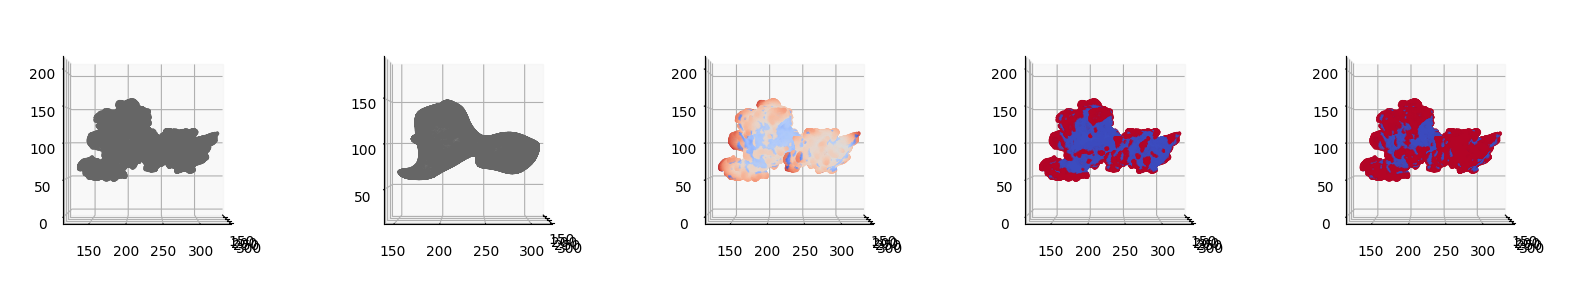

In [57]:
import skimage.filters as skfilters

# obtain the binary segmentation by mean value
cutoff_h_cMCF = np.nanmean(h_cMCF)
binary_h_cMCF = h_cMCF > cutoff_h_cMCF

# obtain the binary segmentation by otsu
cutoff_h_cMCF_otsu = skfilters.threshold_otsu(h_cMCF)
binary_h_cMCF_otsu = h_cMCF > cutoff_h_cMCF_otsu

# create colors for height and binary
h_cMCF_colors = vol_colors.get_colors(h_cMCF, 
                                        colormap=cm.coolwarm,
                                        vmin=np.percentile(h_cMCF,1),
                                        vmax=np.percentile(h_cMCF,99))

binary_h_cMCF_colors = vol_colors.get_colors(binary_h_cMCF*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

binary_h_cMCF_otsu_colors = vol_colors.get_colors(binary_h_cMCF_otsu*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

# visualize
sampling = 2

fig = plt.figure(figsize=(4*5,5))
ax = fig.add_subplot(1,5,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,2, projection='3d')
ax.scatter(cMCF_S_ref.vertices[::sampling,0], 
            cMCF_S_ref.vertices[::sampling,1],
            cMCF_S_ref.vertices[::sampling,2], 
            s=0.1, 
            c=cMCF_S_ref.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,3, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=h_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,4, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,5, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_cMCF_otsu_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

##### cMCF + distance function $S_\text{ref}(x,y,z)$ 

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. 

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S_\text{ref}(x,y,z)$, 
3. $h_\text{cMCF}$ 

and the binary segmentation by: 

4. mean value,
5. Otsu's method

##### ALS baseline $S_\text{ref}(d,u,v)$

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. Since the segmentation is in $(d,u,v)$ space, we will show the following plots in topography space, then we will then map $S(d,u,v)$ mesh back to $(x,y,z)$ space for comparison, consistent with the other height functions.

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S_\text{ref}(x,y,z)$, 
3. $h_\text{cMCF}$ 

and the binary segmentation by: 

4. mean value,
5. Otsu's method